# Classification

In this section we're going to classify certain images and extract their visual value.
The MNIST data set is a set of 70,000 images of handwritten numbers

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

c:\users\jorge\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\datasets\_openml.py:57: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

We have 70,000 images with each 28x28=784 pixels, and each intensity represent from 0 (white) to 255 (black)

In [3]:
y.shape

(70000,)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

<function matplotlib.pyplot.show(*args, **kw)>

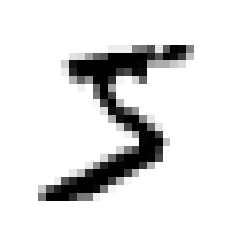

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show

In [6]:
y[42]

'7'

In [7]:
y = y.astype(np.uint8)

## Test and training set

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

We restrict ourselves with only one digit for example 5, i.e, the classifier will detect 5 and not 5

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

One classifier is the SGD (Stochastic Gradient Descent) on scikit-learn

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #random_State only if you want reproducible results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

### Performance measures
Evaluating a classifier is trickier than evaluating a regressor. To evaluate a model is to use cross-validation.

The following code is the same thing as Scikit-Learn's cross_val_score(), but the difference relies that this algorithm produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier. trains that clone on the traininf folds, and makes predictions on the test fold, finally counts the number of correct predictions.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.8642
0.87215
0.88795


However let's use cross_val_score() to evaluate SGDClassifier, this function split the training set into K folds then make predictions and evaluate

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

This is a dumb prediction because the cross-validation folds only look for those that are 5 and those that don't, so indeed there would be a 93% accuracy due to the amount of data.

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

MemoryError: Unable to allocate 239. MiB for an array with shape (40000, 784) and data type float64

This demonstrates why accuracy is generally not the preferredperformance measure for classifiers, especially when you are dealing withskewed datasets.

### Confusion Matrix

This is a better way to evaluate the performance of a classifier is to look at the confusion matrix, which count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would loof in the fifth row and third column of the confusiion matrix.

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

MemoryError: Unable to allocate 239. MiB for an array with shape (40000, 784) and data type float64

So this function is like cross_val_score but instead of returning the score, returns the prediction.

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

NameError: name 'y_train_pred' is not defined

Each row represnts an actual class, each column represents a predicted class, the first row considers non-5 images (negative class), 53,057 true negatives, 1,522 false positives, 1,325(false negative) and 4,096 true positives.

This would be a perfect confusion matrix

In [ ]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

$Precision = \frac{TP}{TP+FP}$
$Recall = \frac{TP}{TP+FN}$

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

This means that the classifier it is correct only $72.9\%$ and only detects $75.6\%$

We define
$F1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = \frac{TP}{TP+\frac{FN+FP}{2}}$

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)